In [1]:
import numpy as np
from numpy import linalg
from sys import stderr
from math import sqrt
import time
import matplotlib
#matplotlib.rcParams.update({'font.size': 13})
import matplotlib.pyplot as plt
import random
import scipy

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

import os
import matplotlib.pyplot as plt

from pathlib import Path
import regex
import glob
import os
import itertools
from collections import namedtuple


In [2]:
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib notebook

In [3]:
os.getcwd()

'/mnt/c/Users/Lenovo/Documents/Projects/ProteinCurvature/robust-surface-curvature/src'

In [4]:
DIR = Path("/mnt/c/Users/Lenovo/Documents/Projects/ProteinCurvature/robust-surface-curvature/")
os.chdir("./..")

## Model comparison

In [5]:
from utils.Hypersphere import fit_hypersphere #Import our model from utils

### Inversion geometry model

In [6]:
def planeFit(points):
    """
    p, n = planeFit(points)

    Given an array, points, of shape (d,...)
    representing points in d-dimensional space,
    fit an d-dimensional plane to the points.
    Return a point, p, on the plane (the point-cloud centroid),
    and the normal, n.
    """
    import numpy as np
    from numpy.linalg import svd
    points = np.transpose(points)
    # Collapse trialing dimensions
    points = np.reshape(points, (np.shape(points)[0], -1))
    assert points.shape[0] <= points.shape[1], "There are only {} points in {} dimensions.".format(
        points.shape[1], points.shape[0])
    ctr = points.mean(axis=1)
    x = points - ctr[:, np.newaxis]
    M = np.dot(x, x.T)  # Could also use np.cov(x) here.
    return ctr, svd(M)[0][:, -1]


def LSF_inversion_geometry(points):
    i = 0
    arr = []
    c_r = []
    dummy = 1e+6
    while i < len(points):
        j = 0
        arr = []
        while j < len(points):
            if j != i:
                x = (points[j]-points[i])/(np.dot((points[j] -
                                                   points[i]), (points[j]-points[i])))+points[i]
                arr.append(x)
            j += 1  # start operation from here--

        lo = points[i]
        d = np.dot((planeFit(arr)[0]-lo), planeFit(arr)[1]) / \
            np.dot(planeFit(arr)[1], planeFit(arr)[1])
        a = d*planeFit(arr)[1]+lo  # point of intersection
        a_1 = (a-lo)/(np.dot((a-lo), (a-lo)))+lo
        c_r.append([(lo+a_1)/2, np.linalg.norm(a_1-lo)/2])
        t = 0
        for j in range(len(points)):
            t = t+np.abs((np.linalg.norm(points[j]-c_r[i][0])-c_r[i][1]))
        if dummy > t:
            dummy = t
            i += 1
        else:
            return c_r[i-1]

## Code for generating Analytical dataset - points on spheres with added noise

In [7]:
class Parent_sphere:

    """Generic Spheres """

    def __init__(self, radius=1, npoints=10):
        self.radius = radius
        self.npoints = npoints

    def __repr__(self):
        return f'Sphere{self.radius,self.npoints!r}'

    def points(self):
        theta = 1*np.pi*np.random.rand(self.npoints)
        phi = 2*np.pi*np.random.rand(self.npoints)
        x = self.radius*np.cos(theta) * np.sin(phi)
        y = self.radius*np.sin(theta) * np.sin(phi)
        z = self.radius*np.cos(phi)
        return np.transpose(np.array([x, y, z]))

In [8]:
class Noisy_spheres(Parent_sphere):

    """Spheres perturbed by addition of Gaussian noise"""

    def __init__(self, radius=1, npoints=100, loc=0.0, scale=1.0):
        super().__init__(radius, npoints)
        self.loc = loc
        self.scale = scale

    def points(self):
        noise = np.random.normal(self.loc, self.scale, size=(self.npoints, 3))
        return super().points()+noise

## Compare inversion_geometry approach with ours

In [9]:
import time
MAE_hyper = []
MAE_inversion_geometry = []
time_hyper = []
time_inversion_geometry = []
for _, (x, y) in enumerate(zip(np.linspace(0.1,10.0,500, endpoint=True), np.linspace(10,5000,500)), 1):
    sph_dat = Noisy_spheres(radius=x, npoints=int(y), scale=0.01).points()
    
    #For writing spheres dataset to data dir
    """
    with open(DIR/"data"/"spheres_dataset"/f"sphere_{_}","w") as f:
        for elem in sph_dat:
            print(elem[0], elem[1], elem[2], file=f)
    """
    
    start_time = time.time()
    result = fit_hypersphere(sph_dat)
    finish_time = time.time()
    MAE_hyper.append(abs(result[0] - x))
    time_hyper.append(finish_time - start_time)
    
    start_time = time.time()
    result = LSF_inversion_geometry(sph_dat)
    finish_time = time.time()
    MAE_inversion_geometry.append(abs(result[1] - x))
    time_inversion_geometry.append(finish_time - start_time)
    
    
    
    
   

<IPython.core.display.Javascript object>


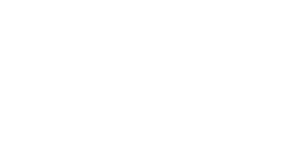

In [10]:
plt.close()
plt.figure()
plt.plot(np.arange(1,501), np.array(MAE_hyper), label="our approach", alpha=0.7)
plt.plot(np.arange(1,501), np.array(MAE_inversion_geometry), label="Coleman's", alpha=0.7)
plt.title("MAE error comparison")
plt.xlabel("Sphere ID")
plt.ylabel("MAE error")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


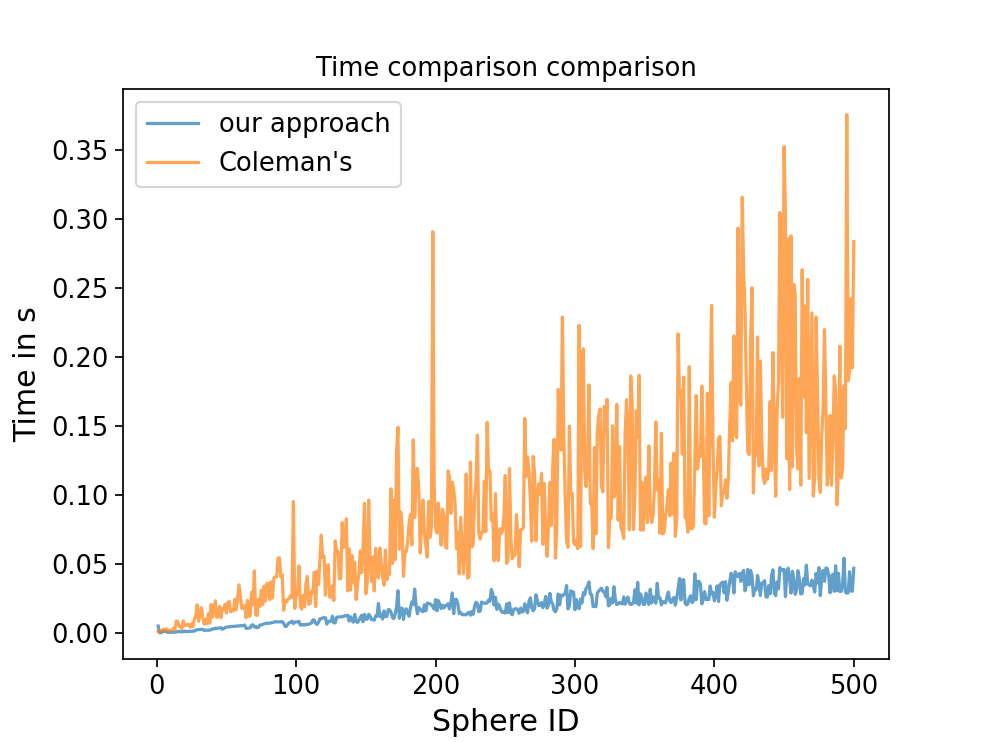

In [11]:
plt.close()
plt.figure()
plt.plot(np.arange(1,501), np.array(time_hyper), label="our approach", alpha=0.7)
plt.plot(np.arange(1,501), np.array(time_inversion_geometry), label="Coleman's", alpha=0.7)
plt.title("Time comparison comparison")
plt.xlabel("Sphere ID")
plt.ylabel("Time in s")
plt.legend()
plt.show()